# Downloading and unpacking the dataset

In [1]:
%pip install gdown --upgrade

In [2]:
import gdown

share_link = 'https://drive.google.com/file/d/1F3LXcQa8zeuJ7F963i4xr2FRGyIM70Cd/view?usp=sharing'
file_id = share_link.split("/d/")[1].split("/view")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, "dataset.rar", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1F3LXcQa8zeuJ7F963i4xr2FRGyIM70Cd
From (redirected): https://drive.google.com/uc?id=1F3LXcQa8zeuJ7F963i4xr2FRGyIM70Cd&confirm=t&uuid=0f4b135d-5da9-4b59-847b-725b821d6012
To: /content/dataset.rar
100%|██████████| 13.0G/13.0G [03:07<00:00, 69.3MB/s]


'dataset.rar'

In [3]:
%%capture

!unrar x dataset.rar

# Filtering movies by YOLO

In [4]:
%pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [5]:
import cv2
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
# We will use YOLO to identify the most informative frames from films.
# It can be assumed that these are mostly those in which there are people
# (actors, main and secondary characters, etc.). This will allow us to remove too general frames,
# from which even a person is unlikely to determine what film they are being shown.

def has_person(image_path, model):
    try:
        results = model(image_path, verbose=False)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return False

    for r in results:
        for obj in r.boxes.cls:
            # 0 - class `person` from YOLO classes
            if int(obj) == 0: return True
    return False


Check YOLO classes [here](https://gist.github.com/rcland12/234e4026fdc547b6015045b60c03f466)

In [7]:
# In addition, to prepare the dataset and reduce its dimensionality:
# 1) Reduce the image size to 600 by 256 pixels;
# 2) Throw out from the dataset those films in which the number of frames after applying
# YOLO is less than 100;

from ultralytics import YOLO

def process_dataset(dataset_path, min_frames=100, target_size=(600, 256)):
    processed_dataset_path = "processed_dataset"
    os.makedirs(processed_dataset_path, exist_ok=True)

    cnt_movies, model = 0, YOLO("yolo11n.pt")
    for movie_dir in tqdm(os.listdir(dataset_path)):
        movie_path = os.path.join(dataset_path, movie_dir)
        processed_movie_path = os.path.join(processed_dataset_path, movie_dir)
        os.makedirs(processed_movie_path, exist_ok=True)

        frame_count, total_count = 0, 0
        for frame_file in os.listdir(movie_path):
            frame_path = os.path.join(movie_path, frame_file)
            img = cv2.imread(frame_path)
            if img is None: continue

            total_count += 1
            resized_img = cv2.resize(img, target_size)
            if has_person(frame_path, model):
                new_frame_path = os.path.join(processed_movie_path, frame_file)
                cv2.imwrite(new_frame_path, resized_img)
                frame_count += 1
            cv2.imwrite(frame_path, resized_img)

        if frame_count < min_frames:
            print(f" '{movie_dir}' (good: {frame_count}, total: {total_count}) - DELETE")
            shutil.rmtree(processed_movie_path)
        else:
            print(f" '{movie_dir}' (good: {frame_count}, total: {total_count}) - ADD")
            cnt_movies += 1

    print(f"\n\nCount of left movies: {cnt_movies}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
process_dataset("dataset")

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.6MB/s]
  0%|          | 1/444 [00:10<1:15:25, 10.22s/it]

 'Wrath Of Man (2021)' (good: 187, total: 263) - ADD


  0%|          | 2/444 [00:15<55:21,  7.51s/it]  

 'Treasure Planet (2002)' (good: 112, total: 298) - ADD


  1%|          | 3/444 [00:16<33:06,  4.51s/it]

 'The Secret Life Of Pets 2 (2019)' (good: 16, total: 44) - DELETE


  1%|          | 4/444 [00:28<54:29,  7.43s/it]

 'Total Recall (1990)' (good: 430, total: 534) - ADD


  1%|          | 5/444 [00:33<48:25,  6.62s/it]

 'Dark City (1998)' (good: 155, total: 228) - ADD


  1%|▏         | 6/444 [00:39<45:10,  6.19s/it]

 'The Pursuit of Happyness (2006)' (good: 244, total: 250) - ADD


  2%|▏         | 7/444 [00:46<47:00,  6.45s/it]

 'Natural Born Killers (1994)' (good: 241, total: 321) - ADD
WARNING ⚠️ Image Read Error /content/dataset/Magnolia (1999)/FRAME_68.jpeg
Error processing image dataset/Magnolia (1999)/FRAME_68.jpeg: need at least one array to stack


  2%|▏         | 8/444 [00:52<45:31,  6.27s/it]

 'Magnolia (1999)' (good: 234, total: 274) - ADD


  2%|▏         | 9/444 [00:57<44:27,  6.13s/it]

 'The Favourite (2018)' (good: 227, total: 250) - ADD


  2%|▏         | 10/444 [01:05<48:08,  6.66s/it]

 'Speed (1994)' (good: 294, total: 366) - ADD


  2%|▏         | 11/444 [01:06<34:21,  4.76s/it]

 'Finding Dory (2016)' (good: 7, total: 24) - DELETE


  3%|▎         | 12/444 [01:07<27:17,  3.79s/it]

 'Saving Mr. Banks (2013)' (good: 46, total: 52) - DELETE


  3%|▎         | 13/444 [01:10<25:08,  3.50s/it]

 'Pretty Woman (1990)' (good: 119, total: 129) - ADD


  3%|▎         | 14/444 [01:11<19:51,  2.77s/it]

 'Logan Lucky (2017)' (good: 44, total: 50) - DELETE


  3%|▎         | 15/444 [01:15<22:31,  3.15s/it]

 'The Breakfast Club (1985)' (good: 161, total: 196) - ADD


  4%|▎         | 16/444 [01:16<17:03,  2.39s/it]

 'Iron Man (2008)' (good: 27, total: 29) - DELETE


  4%|▍         | 17/444 [01:20<21:41,  3.05s/it]

 'King Kong (2005)' (good: 115, total: 185) - ADD


  4%|▍         | 18/444 [01:30<34:40,  4.88s/it]

 'King Richard (2021)' (good: 394, total: 417) - ADD


  4%|▍         | 19/444 [01:37<40:32,  5.72s/it]

 'Apocalypto (2006)' (good: 283, total: 338) - ADD


  5%|▍         | 20/444 [01:43<40:59,  5.80s/it]

 'Gravity (2013)' (good: 125, total: 269) - ADD


  5%|▍         | 21/444 [01:45<33:00,  4.68s/it]

 'Kubo And The Two Strings (2016)' (good: 42, total: 83) - DELETE


  5%|▍         | 22/444 [01:49<31:08,  4.43s/it]

 'The Usual Suspects (1995)' (good: 155, total: 182) - ADD


  5%|▌         | 23/444 [01:53<30:31,  4.35s/it]

 'Blue Valentine (2010)' (good: 195, total: 214) - ADD


  5%|▌         | 24/444 [01:54<23:20,  3.34s/it]

 'Finding Nemo (2003)' (good: 9, total: 47) - DELETE


  6%|▌         | 25/444 [02:07<43:10,  6.18s/it]

 'Ray (2004)' (good: 510, total: 597) - ADD


  6%|▌         | 26/444 [02:15<46:38,  6.70s/it]

 'Lucky Number Slevin (2006)' (good: 328, total: 400) - ADD


  6%|▌         | 27/444 [02:24<50:45,  7.30s/it]

 'Nightmare Alley (2021)' (good: 370, total: 416) - ADD


  6%|▋         | 28/444 [02:29<46:23,  6.69s/it]

 'Apollo 13 (1995)' (good: 217, total: 251) - ADD


  7%|▋         | 29/444 [02:30<33:44,  4.88s/it]

 'Cape Fear (1991)' (good: 24, total: 30) - DELETE


  7%|▋         | 30/444 [02:30<24:48,  3.60s/it]

 'Identity (2003)' (good: 28, total: 29) - DELETE


  7%|▋         | 31/444 [02:33<23:21,  3.39s/it]

 'Dawn of the Planet of the Apes (2014)' (good: 65, total: 110) - DELETE


  7%|▋         | 32/444 [02:35<20:44,  3.02s/it]

 'Dredd (2012)' (good: 72, total: 102) - DELETE


  7%|▋         | 33/444 [02:47<38:30,  5.62s/it]

 'The Place Beyond the Pines (2012)' (good: 451, total: 527) - ADD


  8%|▊         | 34/444 [02:48<29:15,  4.28s/it]

 'Drive (2011)' (good: 46, total: 53) - DELETE


  8%|▊         | 35/444 [02:49<22:54,  3.36s/it]

 'Frozen (2013)' (good: 41, total: 59) - DELETE


  8%|▊         | 36/444 [02:50<17:09,  2.52s/it]

 'Snowden (2016)' (good: 24, total: 27) - DELETE


  8%|▊         | 37/444 [02:51<13:22,  1.97s/it]

 'Election (1999)' (good: 29, total: 31) - DELETE


  9%|▊         | 38/444 [03:01<30:27,  4.50s/it]

 'The Curious Case of Benjamin Button (2008)' (good: 422, total: 473) - ADD


  9%|▉         | 39/444 [03:13<46:19,  6.86s/it]

 'War Horse (2011)' (good: 471, total: 545) - ADD


  9%|▉         | 40/444 [03:14<34:08,  5.07s/it]

 'The Hunger Games (2012)' (good: 31, total: 39) - DELETE


  9%|▉         | 41/444 [03:15<24:32,  3.65s/it]

 'Mean Girls (2004)' (good: 15, total: 16) - DELETE


  9%|▉         | 42/444 [03:17<21:05,  3.15s/it]

 'Star Trek Beyond (2016)' (good: 67, total: 95) - DELETE


 10%|▉         | 43/444 [03:17<16:02,  2.40s/it]

 'Cop Land (1997)' (good: 26, total: 32) - DELETE


 10%|▉         | 44/444 [03:33<43:05,  6.46s/it]

 'Unbroken (2014)' (good: 604, total: 705) - ADD


 10%|█         | 45/444 [03:53<1:09:18, 10.42s/it]

 'Babylon (2022)' (good: 756, total: 878) - ADD


 10%|█         | 46/444 [04:00<1:01:54,  9.33s/it]

 'Spy Game (2001)' (good: 256, total: 293) - ADD


 11%|█         | 47/444 [04:04<51:07,  7.73s/it]  

 'The Road (2009)' (good: 146, total: 208) - ADD


 11%|█         | 48/444 [04:13<53:54,  8.17s/it]

 'Charlie and the Chocolate Factory (2005)' (good: 316, total: 442) - ADD


 11%|█         | 49/444 [04:28<1:07:20, 10.23s/it]

 'Harry Potter And The Half-Blood Prince (2009)' (good: 537, total: 726) - ADD


 11%|█▏        | 50/444 [04:29<49:04,  7.47s/it]  

 'Despicable Me (2010)' (good: 34, total: 52) - DELETE


 11%|█▏        | 51/444 [04:37<49:49,  7.61s/it]

 'The Devil All The Time (2020)' (good: 256, total: 314) - ADD


 12%|█▏        | 52/444 [04:38<37:42,  5.77s/it]

 'The Departed (2006)' (good: 62, total: 68) - DELETE


 12%|█▏        | 53/444 [04:39<28:17,  4.34s/it]

 'The Hateful Eight (2015)' (good: 37, total: 44) - DELETE


 12%|█▏        | 54/444 [04:45<31:38,  4.87s/it]

 'Children of Men (2006)' (good: 218, total: 261) - ADD


 12%|█▏        | 55/444 [04:52<34:27,  5.31s/it]

 'Notting Hill (1999)' (good: 296, total: 325) - ADD


 13%|█▎        | 56/444 [04:54<27:30,  4.25s/it]

 'T2 Trainspotting (2017)' (good: 77, total: 87) - DELETE


 13%|█▎        | 57/444 [05:07<46:09,  7.16s/it]

 'Blade Runner 2049 (2017)' (good: 460, total: 635) - ADD


 13%|█▎        | 58/444 [05:13<43:07,  6.70s/it]

 'The Killing Of A Sacred Deer (2017)' (good: 217, total: 244) - ADD


 13%|█▎        | 59/444 [05:14<30:59,  4.83s/it]

 'Zootopia (2016)' (good: 10, total: 20) - DELETE


 14%|█▎        | 60/444 [05:15<25:06,  3.92s/it]

 'Indiana Jones and the Last Crusade (1989)' (good: 63, total: 76) - DELETE


 14%|█▎        | 61/444 [05:16<18:56,  2.97s/it]

 'Blue Jasmine (2013)' (good: 30, total: 32) - DELETE


 14%|█▍        | 62/444 [05:22<23:37,  3.71s/it]

 'Escape from New York (1981)' (good: 155, total: 234) - ADD


 14%|█▍        | 63/444 [05:23<18:55,  2.98s/it]

 'The Prestige (2006)' (good: 49, total: 60) - DELETE


 14%|█▍        | 64/444 [05:30<26:39,  4.21s/it]

 '10 Things I Hate About You (1999)' (good: 310, total: 338) - ADD


 15%|█▍        | 65/444 [05:35<28:29,  4.51s/it]

 'Wild (2014)' (good: 194, total: 215) - ADD


 15%|█▍        | 66/444 [05:40<28:38,  4.55s/it]

 'The Big Sick (2017)' (good: 214, total: 240) - ADD


 15%|█▌        | 67/444 [05:46<30:48,  4.90s/it]

 'Jojo Rabbit (2019)' (good: 205, total: 245) - ADD


 16%|█▌        | 69/444 [05:59<33:06,  5.30s/it]

 'Prisoners (2013)' (good: 531, total: 665) - ADD
 'Limitless (2011)' (good: 5, total: 5) - DELETE


 16%|█▌        | 70/444 [06:00<24:42,  3.96s/it]

 'Paddington (2014)' (good: 22, total: 38) - DELETE


 16%|█▌        | 71/444 [06:16<46:20,  7.45s/it]

 'Dune (2021)' (good: 506, total: 732) - ADD


 16%|█▌        | 72/444 [06:22<44:02,  7.10s/it]

 'Booksmart (2019)' (good: 249, total: 270) - ADD


 16%|█▋        | 73/444 [06:30<46:07,  7.46s/it]

 'Casino (1995)' (good: 342, total: 382) - ADD


 17%|█▋        | 74/444 [06:35<40:59,  6.65s/it]

 'Avatar (2009)' (good: 124, total: 198) - ADD


 17%|█▋        | 75/444 [06:45<47:50,  7.78s/it]

 'John Wick (2014)' (good: 412, total: 485) - ADD


 17%|█▋        | 76/444 [06:52<45:36,  7.44s/it]

 'Jumanji (1995)' (good: 245, total: 328) - ADD


 17%|█▋        | 77/444 [07:00<46:48,  7.65s/it]

 'A League of Their Own (1992)' (good: 329, total: 346) - ADD


 18%|█▊        | 78/444 [07:01<34:15,  5.62s/it]

 'Furious 6 (2013)' (good: 38, total: 41) - DELETE


 18%|█▊        | 79/444 [07:01<24:26,  4.02s/it]

 'Cube (1997)' (good: 13, total: 14) - DELETE


 18%|█▊        | 80/444 [07:02<18:28,  3.05s/it]

 'Pitch Black (2000)' (good: 26, total: 36) - DELETE


 18%|█▊        | 81/444 [07:05<17:21,  2.87s/it]

 'Lion (2016)' (good: 104, total: 124) - ADD


 18%|█▊        | 82/444 [07:10<20:58,  3.48s/it]

 'Michael Clayton (2007)' (good: 188, total: 207) - ADD


 19%|█▊        | 83/444 [07:16<26:37,  4.43s/it]

 'The Florida Project (2017)' (good: 294, total: 304) - ADD


 19%|█▉        | 84/444 [07:26<37:06,  6.19s/it]

 'Braveheart (1995)' (good: 401, total: 435) - ADD


 19%|█▉        | 85/444 [07:28<28:56,  4.84s/it]

 'Beauty And The Beast (2017)' (good: 49, total: 80) - DELETE


 19%|█▉        | 86/444 [07:29<22:34,  3.78s/it]

 'The Fugitive (1993)' (good: 60, total: 64) - DELETE


 20%|█▉        | 87/444 [07:41<36:58,  6.21s/it]

 'Melancholia (2011)' (good: 468, total: 548) - ADD


 20%|█▉        | 88/444 [07:46<34:48,  5.87s/it]

 'True Romance (1993)' (good: 157, total: 193) - ADD


 20%|██        | 89/444 [07:48<27:46,  4.69s/it]

 'Zero Dark Thirty (2012)' (good: 72, total: 94) - DELETE


 20%|██        | 90/444 [07:49<20:16,  3.44s/it]

 'Rambo (2008)' (good: 12, total: 21) - DELETE


 20%|██        | 91/444 [08:01<34:51,  5.93s/it]

 'Grease (1978)' (good: 413, total: 479) - ADD


 21%|██        | 92/444 [08:05<32:29,  5.54s/it]

 'We Need to Talk About Kevin (2011)' (good: 183, total: 221) - ADD


 21%|██        | 93/444 [08:12<33:44,  5.77s/it]

 'Being John Malkovich (1999)' (good: 251, total: 288) - ADD


 21%|██        | 94/444 [08:12<24:47,  4.25s/it]

 'Filth (2013)' (good: 28, total: 32) - DELETE


 21%|██▏       | 95/444 [08:14<20:15,  3.48s/it]

 'Rush (2013)' (good: 60, total: 79) - DELETE


 22%|██▏       | 96/444 [08:15<15:19,  2.64s/it]

 'Moulin Rouge! (2001)' (good: 26, total: 30) - DELETE


 22%|██▏       | 97/444 [08:27<31:22,  5.43s/it]

 'Harry Potter And The Chamber Of Secrets (2002)' (good: 371, total: 528) - ADD


 22%|██▏       | 98/444 [08:40<45:00,  7.81s/it]

 'The Grand Budapest Hotel (2014)' (good: 550, total: 656) - ADD


 22%|██▏       | 99/444 [08:40<32:15,  5.61s/it]

 'Wonder (2017)' (good: 17, total: 21) - DELETE


 23%|██▎       | 100/444 [08:47<33:59,  5.93s/it]

 'Burn After Reading (2008)' (good: 268, total: 299) - ADD


 23%|██▎       | 101/444 [08:55<36:52,  6.45s/it]

 'The Banshees Of Inisherin (2022)' (good: 283, total: 368) - ADD


 23%|██▎       | 102/444 [09:09<50:56,  8.94s/it]

 'Indiana Jones And The Temple Of Doom (1984)' (good: 587, total: 610) - ADD


 23%|██▎       | 103/444 [09:10<36:41,  6.46s/it]

 'Munich (2005)' (good: 28, total: 30) - DELETE


 23%|██▎       | 104/444 [09:15<33:05,  5.84s/it]

 'Babel (2006)' (good: 190, total: 219) - ADD


 24%|██▎       | 105/444 [09:19<31:04,  5.50s/it]

 'The Girl with the Dragon Tattoo (2011)' (good: 193, total: 230) - ADD


 24%|██▍       | 106/444 [09:20<23:04,  4.10s/it]

 'The Sixth Sense (1999)' (good: 27, total: 30) - DELETE


 24%|██▍       | 107/444 [09:21<17:48,  3.17s/it]

 'Doubt (2008)' (good: 28, total: 32) - DELETE


 24%|██▍       | 108/444 [09:28<23:40,  4.23s/it]

 'Point Break (1991)' (good: 251, total: 322) - ADD


 25%|██▍       | 109/444 [09:29<18:10,  3.25s/it]

 'I, Tonya (2017)' (good: 45, total: 46) - DELETE


 25%|██▍       | 110/444 [09:34<21:17,  3.83s/it]

 'The Wrestler (2008)' (good: 195, total: 206) - ADD


 25%|██▌       | 111/444 [09:43<30:10,  5.44s/it]

 'Batman (1989)' (good: 341, total: 482) - ADD


 25%|██▌       | 112/444 [09:47<26:43,  4.83s/it]

 'Baby Driver (2017)' (good: 118, total: 130) - ADD


 25%|██▌       | 113/444 [09:47<19:33,  3.55s/it]

 'Coraline (2009)' (good: 16, total: 27) - DELETE


 26%|██▌       | 114/444 [09:48<14:34,  2.65s/it]

 'Mulholland Drive (2001)' (good: 26, total: 29) - DELETE


 26%|██▌       | 115/444 [09:49<12:16,  2.24s/it]

 'The Thin Red Line (1998)' (good: 42, total: 59) - DELETE


 26%|██▌       | 116/444 [09:53<15:35,  2.85s/it]

 'The Lobster (2015)' (good: 187, total: 214) - ADD


 26%|██▋       | 117/444 [09:57<17:42,  3.25s/it]

 'There Will Be Blood (2007)' (good: 150, total: 168) - ADD


 27%|██▋       | 118/444 [10:02<20:25,  3.76s/it]

 'The Hurt Locker (2008)' (good: 212, total: 246) - ADD


 27%|██▋       | 119/444 [10:07<21:14,  3.92s/it]

 'Midnight In Paris (2011)' (good: 171, total: 208) - ADD


 27%|██▋       | 120/444 [10:14<26:21,  4.88s/it]

 'Gangs of New York (2002)' (good: 271, total: 296) - ADD


 27%|██▋       | 121/444 [10:30<45:07,  8.38s/it]

 'Ben-Hur (1959)' (good: 629, total: 689) - ADD


 27%|██▋       | 122/444 [10:33<35:45,  6.66s/it]

 'Looper (2012)' (good: 84, total: 101) - DELETE


 28%|██▊       | 124/444 [10:38<23:25,  4.39s/it]

 'St. Vincent (2014)' (good: 235, total: 250) - ADD
 'The Ides of March (2011)' (good: 4, total: 5) - DELETE


 28%|██▊       | 125/444 [10:49<33:28,  6.29s/it]

 'Hot Fuzz (2007)' (good: 417, total: 462) - ADD


 28%|██▊       | 126/444 [10:53<29:47,  5.62s/it]

 'Wind River (2017)' (good: 160, total: 193) - ADD


 29%|██▊       | 127/444 [11:00<31:27,  5.95s/it]

 'The Father (2020)' (good: 269, total: 299) - ADD


 29%|██▉       | 128/444 [11:03<27:13,  5.17s/it]

 'The Master (2012)' (good: 157, total: 165) - ADD


 29%|██▉       | 129/444 [11:08<26:20,  5.02s/it]

 'Crimson Tide (1995)' (good: 194, total: 222) - ADD


 29%|██▉       | 130/444 [11:09<19:50,  3.79s/it]

 'The Bourne identity (2002)' (good: 28, total: 33) - DELETE


 30%|██▉       | 131/444 [11:13<21:07,  4.05s/it]

 'Good Time (2017)' (good: 149, total: 207) - ADD


 30%|██▉       | 132/444 [11:27<36:28,  7.02s/it]

 'American Gangster (2007)' (good: 593, total: 689) - ADD


 30%|██▉       | 133/444 [11:28<27:17,  5.26s/it]

 'Nebraska (2013)' (good: 48, total: 55) - DELETE


 30%|███       | 134/444 [11:30<20:43,  4.01s/it]

 'Galaxy Quest (1999)' (good: 42, total: 50) - DELETE


 30%|███       | 135/444 [11:36<24:07,  4.68s/it]

 'Warrior (2011)' (good: 210, total: 264) - ADD


 31%|███       | 136/444 [11:51<39:34,  7.71s/it]

 'La La Land (2016)' (good: 578, total: 657) - ADD


 31%|███       | 137/444 [11:52<29:24,  5.75s/it]

 'Boyhood (2014)' (good: 52, total: 53) - DELETE


 31%|███       | 138/444 [11:58<29:46,  5.84s/it]

 'Never Let Me Go (2010)' (good: 203, total: 249) - ADD


 31%|███▏      | 139/444 [11:58<21:26,  4.22s/it]

 'The Lincoln Lawyer (2011)' (good: 19, total: 21) - DELETE


 32%|███▏      | 140/444 [12:03<21:43,  4.29s/it]

 'The Lighthouse (2019)' (good: 210, total: 248) - ADD


 32%|███▏      | 141/444 [12:03<16:04,  3.18s/it]

 'Tremors (1990)' (good: 22, total: 29) - DELETE


 32%|███▏      | 142/444 [12:05<13:15,  2.64s/it]

 'The Imitation Game (2014)' (good: 56, total: 63) - DELETE


 32%|███▏      | 143/444 [12:06<11:36,  2.31s/it]

 'American Sniper (2014)' (good: 62, total: 74) - DELETE


 32%|███▏      | 144/444 [12:07<08:50,  1.77s/it]

 'Brick (2005)' (good: 23, total: 26) - DELETE


 33%|███▎      | 145/444 [12:13<15:25,  3.10s/it]

 'Desperado (1995)' (good: 225, total: 270) - ADD


 33%|███▎      | 146/444 [12:14<11:44,  2.36s/it]

 'The Gift (2015)' (good: 23, total: 32) - DELETE


 33%|███▎      | 147/444 [12:16<11:15,  2.27s/it]

 'Catch Me If You Can (2002)' (good: 95, total: 103) - DELETE


 33%|███▎      | 148/444 [12:17<10:18,  2.09s/it]

 'Three Billboards Outside Ebbing, Missouri (2017)' (good: 57, total: 78) - DELETE


 34%|███▎      | 149/444 [12:28<22:19,  4.54s/it]

 'Life of Pi (2012)' (good: 323, total: 485) - ADD


 34%|███▍      | 150/444 [12:30<19:21,  3.95s/it]

 'Before Midnight (2013)' (good: 121, total: 125) - ADD


 34%|███▍      | 151/444 [12:31<14:23,  2.95s/it]

 'Up In The Air (2009)' (good: 26, total: 28) - DELETE


 34%|███▍      | 152/444 [12:36<18:11,  3.74s/it]

 'Dazed and Confused (1993)' (good: 207, total: 243) - ADD


 34%|███▍      | 153/444 [12:41<20:00,  4.12s/it]

 'Finding Neverland (2004)' (good: 219, total: 238) - ADD


 35%|███▍      | 154/444 [12:49<25:03,  5.18s/it]

 'Man On The Moon (1999)' (good: 316, total: 335) - ADD


 35%|███▍      | 155/444 [12:58<30:41,  6.37s/it]

 'Boogie Nights (1997)' (good: 366, total: 407) - ADD


 35%|███▌      | 156/444 [13:18<49:41, 10.35s/it]

 'No Time To Die (2021)' (good: 725, total: 908) - ADD


 35%|███▌      | 157/444 [13:18<35:21,  7.39s/it]

 'The Kids Are All Right (2010)' (good: 22, total: 23) - DELETE


 36%|███▌      | 158/444 [13:26<35:49,  7.52s/it]

 'Moonrise Kingdom (2012)' (good: 270, total: 347) - ADD


 36%|███▌      | 159/444 [13:27<26:14,  5.53s/it]

 'Vice (2018)' (good: 33, total: 41) - DELETE


 36%|███▌      | 160/444 [13:28<19:07,  4.04s/it]

 'The Full Monty (1997)' (good: 27, total: 28) - DELETE


 36%|███▋      | 161/444 [13:33<20:55,  4.44s/it]

 'Dunkirk (2017)' (good: 171, total: 252) - ADD


 36%|███▋      | 162/444 [13:40<24:42,  5.26s/it]

 'Pulp Fiction (1994)' (good: 283, total: 330) - ADD


 37%|███▋      | 163/444 [13:45<24:00,  5.13s/it]

 'Atonement (2007)' (good: 199, total: 223) - ADD


 37%|███▋      | 164/444 [13:46<18:06,  3.88s/it]

 'The Big Short (2015)' (good: 29, total: 30) - DELETE


 37%|███▋      | 165/444 [14:00<31:49,  6.84s/it]

 'Les Misérables (2012)' (good: 591, total: 665) - ADD


 37%|███▋      | 166/444 [14:06<30:43,  6.63s/it]

 'Man on Fire (2004)' (good: 234, total: 289) - ADD


 38%|███▊      | 167/444 [14:06<22:20,  4.84s/it]

 'Side Effects (2013)' (good: 28, total: 33) - DELETE


 38%|███▊      | 168/444 [14:13<24:36,  5.35s/it]

 'True Grit (2010)' (good: 241, total: 274) - ADD


 38%|███▊      | 169/444 [14:26<34:41,  7.57s/it]

 'Spirited Away (2001)' (good: 172, total: 610) - ADD


 38%|███▊      | 170/444 [14:38<40:46,  8.93s/it]

 'The Princess Bride (1987)' (good: 559, total: 578) - ADD


 39%|███▊      | 171/444 [14:39<29:43,  6.53s/it]

 'Philomena (2013)' (good: 39, total: 46) - DELETE


 39%|███▊      | 172/444 [14:46<30:37,  6.76s/it]

 'Everything Everywhere All At Once (2022)' (good: 290, total: 328) - ADD


 39%|███▉      | 173/444 [14:47<22:27,  4.97s/it]

 'Super 8 (2011)' (good: 31, total: 37) - DELETE


 39%|███▉      | 174/444 [14:56<28:07,  6.25s/it]

 'A Beautiful Mind (2001)' (good: 417, total: 463) - ADD


 39%|███▉      | 175/444 [14:58<22:41,  5.06s/it]

 'Darkest Hour (2017)' (good: 80, total: 88) - DELETE


 40%|███▉      | 176/444 [15:03<21:36,  4.84s/it]

 'Carol (2015)' (good: 202, total: 218) - ADD


 40%|███▉      | 177/444 [15:05<17:33,  3.94s/it]

 'Logan (2017)' (good: 83, total: 91) - DELETE


 40%|████      | 178/444 [15:18<29:48,  6.72s/it]

 'The Batman (2022)' (good: 427, total: 661) - ADD


 40%|████      | 179/444 [15:32<39:33,  8.96s/it]

 'Barbie (2023)' (good: 582, total: 644) - ADD


 41%|████      | 180/444 [15:32<28:11,  6.41s/it]

 'Chef (2014)' (good: 10, total: 14) - DELETE


 41%|████      | 181/444 [15:34<21:10,  4.83s/it]

 'Highlander (1986)' (good: 33, total: 40) - DELETE


 41%|████      | 182/444 [15:48<34:00,  7.79s/it]

 'Ford V Ferrari (2019)' (good: 569, total: 667) - ADD


 41%|████      | 183/444 [15:49<24:37,  5.66s/it]

 'Unbreakable (2000)' (good: 29, total: 33) - DELETE


 41%|████▏     | 184/444 [15:56<26:41,  6.16s/it]

 'Gattaca (1997)' (good: 279, total: 351) - ADD


 42%|████▏     | 185/444 [16:13<39:52,  9.24s/it]

 'Fear And Loathing In Las Vegas (1998)' (good: 587, total: 693) - ADD


 42%|████▏     | 186/444 [16:29<48:29, 11.28s/it]

 'The Fall (2006)' (good: 573, total: 758) - ADD


 42%|████▏     | 187/444 [16:40<48:24, 11.30s/it]

 'Pleasantville (1998)' (good: 422, total: 522) - ADD


 42%|████▏     | 188/444 [16:41<35:00,  8.21s/it]

 'Independence Day (1996)' (good: 24, total: 44) - DELETE


 43%|████▎     | 189/444 [16:41<24:59,  5.88s/it]

 'The Illusionist (2006)' (good: 19, total: 22) - DELETE


 43%|████▎     | 190/444 [16:42<18:41,  4.41s/it]

 'The Theory of Everything (2014)' (good: 40, total: 44) - DELETE


 43%|████▎     | 191/444 [16:51<24:09,  5.73s/it]

 'Heat (1995)' (good: 340, total: 389) - ADD


 43%|████▎     | 192/444 [17:06<35:29,  8.45s/it]

 'First Man (2018)' (good: 485, total: 687) - ADD


 43%|████▎     | 193/444 [17:07<25:41,  6.14s/it]

 'Seven Psychopaths (2012)' (good: 33, total: 34) - DELETE


 44%|████▎     | 194/444 [17:10<21:38,  5.19s/it]

 'Star Trek (2009)' (good: 88, total: 117) - DELETE


 44%|████▍     | 195/444 [17:14<20:03,  4.83s/it]

 'The Assassination Of Jesse James By The Coward Robert Ford (2007)' (good: 163, total: 185) - ADD


 44%|████▍     | 196/444 [17:23<24:48,  6.00s/it]

 'Wedding Crashers (2005)' (good: 360, total: 371) - ADD


 44%|████▍     | 197/444 [17:25<20:05,  4.88s/it]

 'RoboCop (1987)' (good: 85, total: 112) - DELETE


 45%|████▍     | 198/444 [17:32<22:57,  5.60s/it]

 'The Founder (2016)' (good: 324, total: 347) - ADD


 45%|████▍     | 199/444 [17:38<23:30,  5.76s/it]

 'Boyz n The Hood (1991)' (good: 249, total: 271) - ADD


 45%|████▌     | 200/444 [17:48<27:58,  6.88s/it]

 'Black Panther (2018)' (good: 327, total: 418) - ADD


 45%|████▌     | 201/444 [17:50<22:27,  5.55s/it]

 'The Hunt for Red October (1990)' (good: 104, total: 123) - ADD


 45%|████▌     | 202/444 [17:51<17:18,  4.29s/it]

 'Up (2009)' (good: 45, total: 69) - DELETE


 46%|████▌     | 203/444 [17:52<13:17,  3.31s/it]

 'Creed II (2018)' (good: 37, total: 49) - DELETE


 46%|████▌     | 204/444 [17:59<17:06,  4.28s/it]

 'A Fish Called Wanda (1988)' (good: 227, total: 239) - ADD


 46%|████▌     | 205/444 [18:10<24:38,  6.19s/it]

 'Elvis (2022)' (good: 418, total: 493) - ADD


 46%|████▋     | 206/444 [18:11<19:16,  4.86s/it]

 'Mud (2012)' (good: 59, total: 70) - DELETE


 47%|████▋     | 207/444 [18:12<14:03,  3.56s/it]

 'Gran Torino (2008)' (good: 23, total: 24) - DELETE


 47%|████▋     | 208/444 [18:14<12:18,  3.13s/it]

 'Star Trek Into Darkness (2013)' (good: 77, total: 99) - DELETE


 47%|████▋     | 209/444 [18:16<10:31,  2.69s/it]

 'American Beauty (1999)' (good: 71, total: 80) - DELETE


 47%|████▋     | 210/444 [18:17<08:31,  2.19s/it]

 'Sing Street (2016)' (good: 47, total: 48) - DELETE


 48%|████▊     | 211/444 [18:23<12:53,  3.32s/it]

 'Past Lives (2023)' (good: 221, total: 266) - ADD


 48%|████▊     | 212/444 [18:28<15:38,  4.05s/it]

 'Lost Highway (1997)' (good: 213, total: 287) - ADD


 48%|████▊     | 213/444 [18:35<18:03,  4.69s/it]

 'Rocketman (2019)' (good: 231, total: 264) - ADD


 48%|████▊     | 214/444 [18:36<14:26,  3.77s/it]

 'Thor (2011)' (good: 63, total: 76) - DELETE


 48%|████▊     | 215/444 [18:52<28:37,  7.50s/it]

 'The Nightmare Before Christmas (1993)' (good: 255, total: 793) - ADD


 49%|████▊     | 216/444 [18:53<20:39,  5.44s/it]

 'The Secret Life Of Pets (2016)' (good: 9, total: 31) - DELETE


 49%|████▉     | 217/444 [18:54<15:34,  4.12s/it]

 'Eternal Sunshine of the Spotless Mind (2004)' (good: 47, total: 52) - DELETE


 49%|████▉     | 218/444 [18:58<15:12,  4.04s/it]

 'Promising Young Woman (2020)' (good: 151, total: 163) - ADD


 49%|████▉     | 219/444 [19:04<17:09,  4.58s/it]

 'Call Me By Your Name (2017)' (good: 230, total: 271) - ADD


 50%|████▉     | 220/444 [19:06<14:40,  3.93s/it]

 'What We Do in the Shadows (2014)' (good: 105, total: 123) - ADD


 50%|████▉     | 221/444 [19:13<17:47,  4.78s/it]

 'Napoleon Dynamite (2004)' (good: 258, total: 298) - ADD


 50%|█████     | 222/444 [19:19<19:00,  5.14s/it]

 'Matchstick Men (2003)' (good: 258, total: 281) - ADD


 50%|█████     | 223/444 [19:21<15:07,  4.11s/it]

 'Superman (1978)' (good: 58, total: 86) - DELETE


 50%|█████     | 224/444 [19:22<12:05,  3.30s/it]

 'Tinker Tailor Soldier Spy (2011)' (good: 47, total: 49) - DELETE


 51%|█████     | 225/444 [19:26<12:19,  3.38s/it]

 'Three Kings (1999)' (good: 134, total: 155) - ADD


 51%|█████     | 226/444 [19:41<25:15,  6.95s/it]

 'Starship Troopers (1997)' (good: 555, total: 726) - ADD


 51%|█████     | 227/444 [19:43<20:07,  5.56s/it]

 'Lawless (2012)' (good: 79, total: 106) - DELETE


 51%|█████▏    | 228/444 [19:50<20:58,  5.83s/it]

 'Milk (2008)' (good: 264, total: 288) - ADD


 52%|█████▏    | 229/444 [19:50<15:06,  4.22s/it]

 'Real Steel (2011)' (good: 20, total: 21) - DELETE


 52%|█████▏    | 230/444 [19:52<12:24,  3.48s/it]

 'The Adventures of Tintin (2011)' (good: 60, total: 83) - DELETE


 52%|█████▏    | 231/444 [19:53<10:01,  2.83s/it]

 'The Lego Movie (2014)' (good: 22, total: 65) - DELETE


 52%|█████▏    | 232/444 [20:00<13:47,  3.90s/it]

 'Se7en (1995)' (good: 223, total: 282) - ADD


 52%|█████▏    | 233/444 [20:07<17:11,  4.89s/it]

 'The Two Popes (2019)' (good: 304, total: 358) - ADD


 53%|█████▎    | 234/444 [20:08<12:54,  3.69s/it]

 'Brooklyn (2015)' (good: 38, total: 43) - DELETE


 53%|█████▎    | 235/444 [20:09<10:26,  3.00s/it]

 'Moana (2016)' (good: 30, total: 60) - DELETE


 53%|█████▎    | 236/444 [20:15<13:17,  3.84s/it]

 'Sound Of Metal (2019)' (good: 201, total: 246) - ADD


 53%|█████▎    | 237/444 [20:27<21:58,  6.37s/it]

 'Oblivion (2013)' (good: 321, total: 575) - ADD


 54%|█████▎    | 238/444 [20:28<16:08,  4.70s/it]

 'The Green Mile (1999)' (good: 34, total: 39) - DELETE


 54%|█████▍    | 239/444 [20:29<12:15,  3.59s/it]

 'Lord of War (2005)' (good: 33, total: 45) - DELETE


 54%|█████▍    | 240/444 [20:29<09:02,  2.66s/it]

 'Southpaw (2015)' (good: 20, total: 23) - DELETE


 54%|█████▍    | 241/444 [20:38<14:31,  4.30s/it]

 'The Perks of Being a Wallflower (2012)' (good: 328, total: 375) - ADD


 55%|█████▍    | 242/444 [20:42<14:21,  4.26s/it]

 'Spotlight (2015)' (good: 194, total: 203) - ADD


 55%|█████▍    | 243/444 [20:42<10:34,  3.16s/it]

 'Invictus (2009)' (good: 20, total: 25) - DELETE


 55%|█████▍    | 244/444 [20:50<15:01,  4.51s/it]

 'An Education (2009)' (good: 303, total: 322) - ADD


 55%|█████▌    | 245/444 [20:59<19:02,  5.74s/it]

 'Soul (2020)' (good: 197, total: 394) - ADD


 55%|█████▌    | 246/444 [20:59<13:56,  4.22s/it]

 'Falling Down (1993)' (good: 25, total: 25) - DELETE


 56%|█████▌    | 247/444 [21:01<10:54,  3.32s/it]

 'How to Train Your Dragon 2 (2014)' (good: 39, total: 58) - DELETE


 56%|█████▌    | 248/444 [21:01<08:25,  2.58s/it]

 'The Help (2011)' (good: 33, total: 38) - DELETE


 56%|█████▌    | 249/444 [21:09<13:37,  4.19s/it]

 'Contact (1997)' (good: 270, total: 367) - ADD


 56%|█████▋    | 250/444 [21:17<16:32,  5.12s/it]

 'Doctor Strange (2016)' (good: 241, total: 333) - ADD


 57%|█████▋    | 251/444 [21:21<16:05,  5.00s/it]

 'Hidden Figures (2016)' (good: 185, total: 219) - ADD


 57%|█████▋    | 252/444 [21:23<12:23,  3.87s/it]

 'Begin Again (2013)' (good: 40, total: 42) - DELETE


 57%|█████▋    | 253/444 [21:38<23:20,  7.33s/it]

 'The Revenant (2015)' (good: 456, total: 689) - ADD


 57%|█████▋    | 254/444 [21:38<16:36,  5.25s/it]

 'The Bourne Ultimatum (2007)' (good: 15, total: 18) - DELETE


 57%|█████▋    | 255/444 [21:41<13:34,  4.31s/it]

 'Steve Jobs (2015)' (good: 92, total: 101) - DELETE


 58%|█████▊    | 256/444 [21:43<11:24,  3.64s/it]

 'Flight (2012)' (good: 90, total: 103) - DELETE


 58%|█████▊    | 257/444 [21:43<08:24,  2.70s/it]

 'The Intern (2015)' (good: 23, total: 23) - DELETE


 58%|█████▊    | 258/444 [21:45<07:32,  2.44s/it]

 'Nightcrawler (2014)' (good: 67, total: 84) - DELETE


 58%|█████▊    | 259/444 [21:52<11:28,  3.72s/it]

 'Friday (1995)' (good: 267, total: 289) - ADD


 59%|█████▊    | 260/444 [21:56<11:44,  3.83s/it]

 'Jackie Brown (1997)' (good: 182, total: 200) - ADD


 59%|█████▉    | 261/444 [22:02<13:47,  4.52s/it]

 'Little Miss Sunshine (2006)' (good: 218, total: 244) - ADD


 59%|█████▉    | 262/444 [22:06<13:15,  4.37s/it]

 'Reservoir Dogs (1992)' (good: 188, total: 193) - ADD


 59%|█████▉    | 263/444 [22:06<09:37,  3.19s/it]

 'Philadelphia (1993)' (good: 18, total: 21) - DELETE


 59%|█████▉    | 264/444 [22:07<07:26,  2.48s/it]

 'Little Children (2006)' (good: 35, total: 39) - DELETE


 60%|█████▉    | 265/444 [22:15<12:08,  4.07s/it]

 'The Virgin Suicides (1999)' (good: 318, total: 355) - ADD


 60%|█████▉    | 266/444 [22:20<12:59,  4.38s/it]

 'The Walk (2015)' (good: 195, total: 242) - ADD


 60%|██████    | 267/444 [22:44<29:54, 10.14s/it]

 'The Super Mario Bros. Movie (2023)' (good: 486, total: 1069) - ADD


 60%|██████    | 268/444 [22:48<25:00,  8.52s/it]

 'The Warriors (1979)' (good: 169, total: 213) - ADD


 61%|██████    | 269/444 [22:54<22:14,  7.63s/it]

 'Fences (2016)' (good: 245, total: 264) - ADD


 61%|██████    | 270/444 [22:59<19:36,  6.76s/it]

 '1917 (2019)' (good: 174, total: 197) - ADD


 61%|██████    | 271/444 [23:04<18:17,  6.34s/it]

 'Sunshine (2007)' (good: 117, total: 281) - ADD


 61%|██████▏   | 272/444 [23:21<26:58,  9.41s/it]

 'Mulan (1998)' (good: 326, total: 867) - ADD


 61%|██████▏   | 273/444 [23:26<23:42,  8.32s/it]

 'Blade (1998)' (good: 199, total: 245) - ADD


 62%|██████▏   | 274/444 [23:31<20:21,  7.19s/it]

 'Mystic River (2003)' (good: 181, total: 213) - ADD


 62%|██████▏   | 275/444 [23:37<19:08,  6.80s/it]

 'War For The Planet Of The Apes (2017)' (good: 136, total: 254) - ADD


 62%|██████▏   | 276/444 [23:37<13:50,  4.94s/it]

 'Green Book (2018)' (good: 23, total: 29) - DELETE


 62%|██████▏   | 277/444 [23:50<20:11,  7.26s/it]

 'Doctor Strange In The Multiverse Of Madness (2022)' (good: 440, total: 569) - ADD


 63%|██████▎   | 278/444 [23:50<14:16,  5.16s/it]

 'Love Actually (2003)' (good: 8, total: 11) - DELETE


 63%|██████▎   | 279/444 [23:51<10:52,  3.96s/it]

 'The LEGO Batman Movie (2017)' (good: 20, total: 55) - DELETE


 63%|██████▎   | 280/444 [23:57<11:52,  4.35s/it]

 'The Northman (2022)' (good: 202, total: 274) - ADD


 63%|██████▎   | 281/444 [24:00<10:43,  3.95s/it]

 'The English Patient (1996)' (good: 90, total: 114) - DELETE


 64%|██████▎   | 282/444 [24:08<14:14,  5.28s/it]

 'The Life Aquatic with Steve Zissou (2004)' (good: 330, total: 393) - ADD


 64%|██████▎   | 283/444 [24:09<10:42,  3.99s/it]

 'Basic Instinct (1992)' (good: 41, total: 49) - DELETE


 64%|██████▍   | 284/444 [24:17<14:00,  5.25s/it]

 'The Game (1997)' (good: 277, total: 378) - ADD


 64%|██████▍   | 285/444 [24:25<15:37,  5.90s/it]

 'The Crow (1994)' (good: 283, total: 382) - ADD


 64%|██████▍   | 286/444 [24:30<15:00,  5.70s/it]

 'Match Point (2005)' (good: 246, total: 263) - ADD


 65%|██████▍   | 287/444 [24:30<10:46,  4.12s/it]

 'Dawn of the Dead (2004)' (good: 18, total: 20) - DELETE


 65%|██████▍   | 288/444 [24:31<07:51,  3.02s/it]

 'Ghost (1990)' (good: 22, total: 24) - DELETE


 65%|██████▌   | 289/444 [24:35<08:27,  3.27s/it]

 'Captain Phillips (2013)' (good: 97, total: 164) - DELETE


 65%|██████▌   | 290/444 [24:35<06:25,  2.50s/it]

 'The Karate Kid (1984)' (good: 19, total: 24) - DELETE


 66%|██████▌   | 291/444 [24:42<09:14,  3.63s/it]

 'No Country For Old Men (2007)' (good: 228, total: 301) - ADD


 66%|██████▌   | 292/444 [24:50<12:38,  4.99s/it]

 'The Post (2017)' (good: 361, total: 382) - ADD


 66%|██████▌   | 293/444 [25:05<20:18,  8.07s/it]

 'Chicago (2002)' (good: 676, total: 733) - ADD


 66%|██████▌   | 294/444 [25:05<14:23,  5.76s/it]

 'Megamind (2010)' (good: 11, total: 17) - DELETE


 66%|██████▋   | 295/444 [25:08<11:51,  4.78s/it]

 'Kick-Ass (2010)' (good: 96, total: 110) - DELETE


 67%|██████▋   | 296/444 [25:21<17:46,  7.21s/it]

 'Shrek (2001)' (good: 381, total: 619) - ADD


 67%|██████▋   | 297/444 [25:22<13:28,  5.50s/it]

 'The Aviator (2004)' (good: 52, total: 59) - DELETE


 67%|██████▋   | 298/444 [25:26<11:42,  4.81s/it]

 'Goodfellas (1990)' (good: 137, total: 142) - ADD
 'Lars and the Real Girl (2007)' (good: 2, total: 2) - DELETE


 68%|██████▊   | 300/444 [25:28<07:48,  3.25s/it]

 'Man of Steel (2013)' (good: 104, total: 129) - ADD


 68%|██████▊   | 301/444 [25:30<06:52,  2.89s/it]

 'Bad Times At The El Royale (2018)' (good: 73, total: 88) - DELETE


 68%|██████▊   | 302/444 [25:31<05:21,  2.26s/it]

 '500 Days Of Summer (2009)' (good: 20, total: 22) - DELETE


 68%|██████▊   | 303/444 [25:40<09:38,  4.10s/it]

 'Guardians Of The Galaxy Vol. 2 (2017)' (good: 221, total: 405) - ADD


 68%|██████▊   | 304/444 [25:53<15:32,  6.66s/it]

 'Brokeback Mountain (2005)' (good: 566, total: 635) - ADD


 69%|██████▊   | 305/444 [25:59<14:42,  6.35s/it]

 'Slumdog Millionaire (2008)' (good: 199, total: 248) - ADD


 69%|██████▉   | 306/444 [26:04<14:12,  6.17s/it]

 'Room (2015)' (good: 233, total: 261) - ADD


 69%|██████▉   | 307/444 [26:06<11:14,  4.92s/it]

 'Straight Outta Compton (2015)' (good: 80, total: 93) - DELETE


 69%|██████▉   | 308/444 [26:11<11:16,  4.97s/it]

 'The Matrix (1999)' (good: 164, total: 211) - ADD


 70%|██████▉   | 309/444 [26:13<08:44,  3.89s/it]

 'Red (2010)' (good: 53, total: 57) - DELETE


 70%|██████▉   | 310/444 [26:13<06:37,  2.97s/it]

 'Billy Elliot (2000)' (good: 38, total: 39) - DELETE


 70%|███████   | 311/444 [26:17<07:13,  3.26s/it]

 'Before Sunrise (1995)' (good: 169, total: 203) - ADD


 70%|███████   | 312/444 [26:19<05:57,  2.71s/it]

 'Transformers (2007)' (good: 32, total: 64) - DELETE


 70%|███████   | 313/444 [26:28<10:18,  4.72s/it]

 'JFK (1991)' (good: 391, total: 426) - ADD


 71%|███████   | 314/444 [26:29<07:27,  3.44s/it]

 'The Mule (2018)' (good: 10, total: 21) - DELETE


 71%|███████   | 315/444 [26:30<05:50,  2.72s/it]

 'Eastern Promises (2007)' (good: 44, total: 48) - DELETE


 71%|███████   | 316/444 [26:41<11:03,  5.18s/it]

 'Silence (2016)' (good: 425, total: 493) - ADD


 71%|███████▏  | 317/444 [26:41<08:12,  3.88s/it]

 'The Impossible (2012)' (good: 28, total: 37) - DELETE


 72%|███████▏  | 318/444 [26:42<06:05,  2.90s/it]

 'The Fighter (2010)' (good: 25, total: 26) - DELETE


 72%|███████▏  | 319/444 [26:45<05:48,  2.79s/it]

 'Rushmore (1998)' (good: 105, total: 113) - ADD


 72%|███████▏  | 320/444 [26:46<04:38,  2.25s/it]

 'Inside Out (2015)' (good: 24, total: 49) - DELETE


 72%|███████▏  | 321/444 [26:51<06:24,  3.12s/it]

 'Captain Fantastic (2016)' (good: 180, total: 210) - ADD


 73%|███████▎  | 322/444 [26:56<07:55,  3.90s/it]

 'Misery (1990)' (good: 207, total: 277) - ADD


 73%|███████▎  | 323/444 [26:58<06:18,  3.13s/it]

 'In Bruges (2008)' (good: 52, total: 59) - DELETE


 73%|███████▎  | 324/444 [27:12<13:10,  6.59s/it]

 'Harry Potter And The Prisoner Of Azkaban (2004)' (good: 435, total: 623) - ADD


 73%|███████▎  | 325/444 [27:13<09:18,  4.69s/it]

 'Buried (2010)' (good: 5, total: 14) - DELETE


 73%|███████▎  | 326/444 [27:24<13:15,  6.74s/it]

 'Kingdom Of Heaven (2005)' (good: 401, total: 527) - ADD


 74%|███████▎  | 327/444 [27:30<12:28,  6.39s/it]

 'The French Connection (1971)' (good: 235, total: 276) - ADD


 74%|███████▍  | 328/444 [27:38<13:39,  7.07s/it]

 'From Dusk Till Dawn (1996)' (good: 347, total: 414) - ADD


 74%|███████▍  | 329/444 [27:54<18:38,  9.72s/it]

 'Aladdin (1992)' (good: 168, total: 814) - ADD


 74%|███████▍  | 330/444 [27:56<13:42,  7.22s/it]

 'Moonlight (2016)' (good: 56, total: 66) - DELETE


 75%|███████▍  | 331/444 [27:56<09:45,  5.18s/it]

 'The Disaster Artist (2017)' (good: 19, total: 20) - DELETE


 75%|███████▍  | 332/444 [27:58<07:45,  4.15s/it]

 'The Rock (1996)' (good: 67, total: 81) - DELETE


 75%|███████▌  | 333/444 [27:59<05:56,  3.21s/it]

 'World War Z (2013)' (good: 24, total: 35) - DELETE


 75%|███████▌  | 334/444 [28:03<06:33,  3.57s/it]

 'A Serious Man (2009)' (good: 177, total: 204) - ADD


 75%|███████▌  | 335/444 [28:09<07:54,  4.36s/it]

 'Eyes Wide Shut (1999)' (good: 288, total: 313) - ADD


 76%|███████▌  | 336/444 [28:22<12:14,  6.80s/it]

 'Hugo (2011)' (good: 502, total: 602) - ADD


 76%|███████▌  | 337/444 [28:23<08:52,  4.98s/it]

 'The Last King of Scotland (2006)' (good: 22, total: 23) - DELETE


 76%|███████▌  | 338/444 [28:25<07:10,  4.06s/it]

 'Silver Linings Playbook (2012)' (good: 66, total: 73) - DELETE


 76%|███████▋  | 339/444 [28:25<05:15,  3.00s/it]

 'This Is England (2006)' (good: 23, total: 25) - DELETE


 77%|███████▋  | 340/444 [28:30<06:11,  3.57s/it]

 'Licorice Pizza (2021)' (good: 215, total: 237) - ADD


 77%|███████▋  | 341/444 [28:39<08:39,  5.05s/it]

 'Fargo (1996)' (good: 319, total: 380) - ADD


 77%|███████▋  | 342/444 [28:41<07:08,  4.20s/it]

 'Foxcatcher (2014)' (good: 94, total: 115) - DELETE


 77%|███████▋  | 343/444 [28:49<08:58,  5.33s/it]

 'Memoirs of a Geisha (2005)' (good: 284, total: 358) - ADD


 77%|███████▋  | 344/444 [28:54<08:46,  5.26s/it]

 'A Star Is Born (2018)' (good: 234, total: 244) - ADD


 78%|███████▊  | 345/444 [29:01<09:42,  5.89s/it]

 'Coach Carter (2005)' (good: 295, total: 318) - ADD


 78%|███████▊  | 346/444 [29:05<08:36,  5.27s/it]

 'Whiplash (2014)' (good: 179, total: 193) - ADD


 78%|███████▊  | 347/444 [29:09<08:07,  5.03s/it]

 'A History of Violence (2005)' (good: 214, total: 238) - ADD


 78%|███████▊  | 348/444 [29:11<06:16,  3.92s/it]

 'Allied (2016)' (good: 46, total: 51) - DELETE


 79%|███████▊  | 349/444 [29:12<04:45,  3.00s/it]

 'Big (1988)' (good: 26, total: 27) - DELETE


 79%|███████▉  | 350/444 [29:20<07:15,  4.64s/it]

 'Constantine (2005)' (good: 296, total: 408) - ADD


 79%|███████▉  | 351/444 [29:21<05:32,  3.58s/it]

 'Ronin (1998)' (good: 45, total: 51) - DELETE


 79%|███████▉  | 352/444 [29:23<04:38,  3.03s/it]

 'The Man From U.N.C.L.E. (2015)' (good: 63, total: 71) - DELETE


 80%|███████▉  | 353/444 [29:31<07:05,  4.67s/it]

 'The Incredibles (2004)' (good: 329, total: 410) - ADD


 80%|███████▉  | 354/444 [29:37<07:28,  4.98s/it]

 'Shaun Of The Dead (2004)' (good: 221, total: 231) - ADD


 80%|███████▉  | 355/444 [29:44<08:23,  5.65s/it]

 'K-PAX (2001)' (good: 255, total: 345) - ADD


 80%|████████  | 356/444 [29:52<09:17,  6.33s/it]

 'The Last Duel (2021)' (good: 310, total: 357) - ADD


 80%|████████  | 357/444 [30:05<11:56,  8.24s/it]

 'Willow (1988)' (good: 446, total: 631) - ADD


 81%|████████  | 358/444 [30:09<09:49,  6.85s/it]

 'The Notebook (2004)' (good: 151, total: 170) - ADD


 81%|████████  | 359/444 [30:12<08:12,  5.79s/it]

 'Sideways (2004)' (good: 114, total: 130) - ADD


 81%|████████  | 360/444 [30:16<07:30,  5.36s/it]

 'Little Women (2019)' (good: 202, total: 213) - ADD


 81%|████████▏ | 361/444 [30:34<12:21,  8.93s/it]

 'Skyfall (2012)' (good: 648, total: 788) - ADD


 82%|████████▏ | 362/444 [30:35<09:04,  6.64s/it]

 'Lost in Translation (2003)' (good: 46, total: 50) - DELETE


 82%|████████▏ | 363/444 [30:36<06:49,  5.06s/it]

 'Source Code (2011)' (good: 38, total: 47) - DELETE


 82%|████████▏ | 364/444 [30:42<07:03,  5.29s/it]

 'Training Day (2001)' (good: 227, total: 270) - ADD


 82%|████████▏ | 365/444 [30:44<05:38,  4.29s/it]

 'Argo (2012)' (good: 76, total: 88) - DELETE


 82%|████████▏ | 366/444 [30:45<04:28,  3.44s/it]

 'Batman Begins (2005)' (good: 42, total: 70) - DELETE


 83%|████████▎ | 367/444 [30:56<07:01,  5.48s/it]

 'The Way Back (2010)' (good: 356, total: 447) - ADD


 83%|████████▎ | 368/444 [31:03<07:40,  6.06s/it]

 'Juno (2007)' (good: 286, total: 326) - ADD


 83%|████████▎ | 369/444 [31:05<06:00,  4.80s/it]

 'Moon (2009)' (good: 42, total: 86) - DELETE


 83%|████████▎ | 370/444 [31:07<04:52,  3.95s/it]

 'Unforgiven (1992)' (good: 81, total: 93) - DELETE


 84%|████████▎ | 371/444 [31:14<05:55,  4.86s/it]

 '127 Hours (2010)' (good: 206, total: 314) - ADD


 84%|████████▍ | 372/444 [31:16<04:53,  4.08s/it]

 'American Hustle (2013)' (good: 97, total: 103) - DELETE


 84%|████████▍ | 373/444 [31:18<03:56,  3.33s/it]

 'Four Weddings And A Funeral (1994)' (good: 69, total: 74) - DELETE


 84%|████████▍ | 374/444 [31:19<02:58,  2.55s/it]

 'They Live (1988)' (good: 31, total: 34) - DELETE


 84%|████████▍ | 375/444 [31:26<04:30,  3.92s/it]

 'Ghost World (2001)' (good: 275, total: 304) - ADD


 85%|████████▍ | 376/444 [31:33<05:40,  5.01s/it]

 'The Equalizer (2014)' (good: 271, total: 366) - ADD


 85%|████████▍ | 377/444 [31:49<09:08,  8.19s/it]

 'The Mummy (1999)' (good: 548, total: 686) - ADD


 85%|████████▌ | 378/444 [31:56<08:48,  8.01s/it]

 'Nomadland (2020)' (good: 298, total: 358) - ADD


 85%|████████▌ | 379/444 [31:59<07:03,  6.51s/it]

 'The Dark Knight Rises (2012)' (good: 104, total: 132) - ADD


 86%|████████▌ | 380/444 [32:06<07:08,  6.69s/it]

 'Bridge Of Spies (2015)' (good: 290, total: 317) - ADD


 86%|████████▌ | 381/444 [32:07<05:01,  4.78s/it]

 'The Adjustment Bureau (2011)' (good: 15, total: 16) - DELETE


 86%|████████▌ | 382/444 [32:07<03:33,  3.44s/it]

 'Serenity (2005)' (good: 10, total: 15) - DELETE


 86%|████████▋ | 383/444 [32:13<04:16,  4.21s/it]

 'The Passion Of The Christ (2004)' (good: 222, total: 246) - ADD


 86%|████████▋ | 384/444 [32:14<03:09,  3.16s/it]

 'In The Line Of Fire (1993)' (good: 30, total: 33) - DELETE


 87%|████████▋ | 385/444 [32:14<02:19,  2.36s/it]

 'The Princess and the Frog (2009)' (good: 12, total: 26) - DELETE


 87%|████████▋ | 386/444 [32:17<02:22,  2.46s/it]

 'Gone Girl (2014)' (good: 107, total: 128) - ADD


 87%|████████▋ | 387/444 [32:18<01:48,  1.90s/it]

 'Now You See Me (2013)' (good: 24, total: 28) - DELETE


 87%|████████▋ | 388/444 [32:22<02:32,  2.72s/it]

 'The Silence Of The Lambs (1991)' (good: 165, total: 230) - ADD


 88%|████████▊ | 389/444 [32:23<02:01,  2.20s/it]

 'In The Name Of The Father (1993)' (good: 30, total: 34) - DELETE


 88%|████████▊ | 390/444 [32:31<03:24,  3.78s/it]

 'The Little Mermaid (2023)' (good: 198, total: 346) - ADD


 88%|████████▊ | 391/444 [32:33<03:01,  3.42s/it]

 'Her (2013)' (good: 120, total: 132) - ADD


 88%|████████▊ | 392/444 [32:46<05:29,  6.34s/it]

 'About Time (2013)' (good: 597, total: 602) - ADD


 89%|████████▊ | 393/444 [33:01<07:25,  8.73s/it]

 'Guardians of the Galaxy (2014)' (good: 447, total: 635) - ADD


 89%|████████▊ | 394/444 [33:06<06:24,  7.70s/it]

 'Creed (2015)' (good: 237, total: 249) - ADD


 89%|████████▉ | 395/444 [33:06<04:29,  5.50s/it]

 'Hotel Transylvania (2012)' (good: 9, total: 18) - DELETE


 89%|████████▉ | 396/444 [33:09<03:42,  4.64s/it]

 '12 Years a Slave (2013)' (good: 111, total: 123) - ADD


 89%|████████▉ | 397/444 [33:19<04:51,  6.20s/it]

 'Interstellar (2014)' (good: 303, total: 451) - ADD


 90%|████████▉ | 398/444 [33:25<04:46,  6.24s/it]

 'Marriage Story (2019)' (good: 275, total: 288) - ADD


 90%|████████▉ | 399/444 [33:26<03:23,  4.52s/it]

 'The Talented Mr. Ripley (1999)' (good: 24, total: 24) - DELETE


 90%|█████████ | 400/444 [33:39<05:13,  7.13s/it]

 'The Martian (2015)' (good: 369, total: 590) - ADD


 90%|█████████ | 401/444 [33:48<05:36,  7.84s/it]

 'The X Files (1998)' (good: 260, total: 433) - ADD


 91%|█████████ | 402/444 [33:50<04:14,  6.07s/it]

 'Hell Or High Water (2016)' (good: 81, total: 90) - DELETE


 91%|█████████ | 403/444 [33:56<04:02,  5.92s/it]

 'Platoon (1986)' (good: 238, total: 310) - ADD


 91%|█████████ | 404/444 [33:57<02:53,  4.33s/it]

 'Hacksaw Ridge (2016)' (good: 24, total: 28) - DELETE


 91%|█████████ | 405/444 [33:57<02:02,  3.15s/it]

 'Memento (2000)' (good: 18, total: 19) - DELETE


 91%|█████████▏| 406/444 [33:58<01:31,  2.40s/it]

 'End of Watch (2012)' (good: 29, total: 33) - DELETE


 92%|█████████▏| 407/444 [34:06<02:34,  4.18s/it]

 'The Danish Girl (2015)' (good: 356, total: 400) - ADD


 92%|█████████▏| 408/444 [34:12<02:53,  4.83s/it]

 'Erin Brockovich (2000)' (good: 264, total: 281) - ADD


 92%|█████████▏| 409/444 [34:17<02:51,  4.91s/it]

 'Million Dollar Baby (2004)' (good: 226, total: 245) - ADD


 92%|█████████▏| 410/444 [34:18<02:00,  3.54s/it]

 'Tangled (2010)' (good: 15, total: 17) - DELETE


 93%|█████████▎| 411/444 [34:18<01:27,  2.65s/it]

 'About Schmidt (2002)' (good: 23, total: 29) - DELETE


 93%|█████████▎| 412/444 [34:26<02:13,  4.19s/it]

 'Bohemian Rhapsody (2018)' (good: 307, total: 346) - ADD


 93%|█████████▎| 413/444 [34:31<02:14,  4.35s/it]

 'Ghostbusters (1984)' (good: 167, total: 219) - ADD


 93%|█████████▎| 414/444 [34:32<01:37,  3.27s/it]

 'Elf (2003)' (good: 31, total: 36) - DELETE


 93%|█████████▎| 415/444 [34:37<01:54,  3.95s/it]

 'Dr. No (1962)' (good: 202, total: 243) - ADD


 94%|█████████▎| 416/444 [34:39<01:37,  3.47s/it]

 'Inside Llewyn Davis (2013)' (good: 113, total: 123) - ADD


 94%|█████████▍| 417/444 [34:41<01:15,  2.78s/it]

 'Nocturnal Animals (2016)' (good: 41, total: 56) - DELETE


 94%|█████████▍| 418/444 [34:42<01:00,  2.32s/it]

 'Zodiac (2007)' (good: 51, total: 59) - DELETE


 94%|█████████▍| 419/444 [34:46<01:12,  2.91s/it]

 'Shame (2011)' (good: 202, total: 213) - ADD


 95%|█████████▍| 420/444 [34:51<01:24,  3.53s/it]

 'Lady Bird (2017)' (good: 203, total: 217) - ADD


 95%|█████████▍| 421/444 [34:55<01:22,  3.61s/it]

 'Legends of the Fall (1994)' (good: 160, total: 188) - ADD


 95%|█████████▌| 422/444 [35:16<03:15,  8.90s/it]

 'Cloud Atlas (2012)' (good: 701, total: 918) - ADD


 95%|█████████▌| 423/444 [35:22<02:44,  7.85s/it]

 'Good Will Hunting (1997)' (good: 234, total: 260) - ADD


 95%|█████████▌| 424/444 [35:22<01:54,  5.71s/it]

 '300 (2006)' (good: 24, total: 32) - DELETE


 96%|█████████▌| 425/444 [35:34<02:22,  7.52s/it]

 'Saving Private Ryan (1998)' (good: 490, total: 512) - ADD


 96%|█████████▌| 426/444 [35:41<02:10,  7.26s/it]

 'Kiss Kiss Bang Bang (2005)' (good: 225, total: 288) - ADD


 96%|█████████▌| 427/444 [35:42<01:34,  5.58s/it]

 'X-Men (2000)' (good: 66, total: 84) - DELETE


 96%|█████████▋| 428/444 [35:43<01:04,  4.01s/it]

 'About a Boy (2002)' (good: 14, total: 15) - DELETE


 97%|█████████▋| 429/444 [35:44<00:49,  3.33s/it]

 'The Shape Of Water (2017)' (good: 77, total: 90) - DELETE


 97%|█████████▋| 430/444 [35:45<00:34,  2.47s/it]

 'Monsters University (2013)' (good: 8, total: 23) - DELETE


 97%|█████████▋| 431/444 [35:46<00:27,  2.13s/it]

 'The Iron Giant (1999)' (good: 33, total: 66) - DELETE


 97%|█████████▋| 432/444 [35:47<00:21,  1.79s/it]

 'Everest (2015)' (good: 21, total: 37) - DELETE


 98%|█████████▊| 433/444 [35:59<00:53,  4.84s/it]

 'The Pianist (2002)' (good: 481, total: 559) - ADD


 98%|█████████▊| 434/444 [36:07<00:56,  5.68s/it]

 'War Dogs (2016)' (good: 280, total: 332) - ADD


 98%|█████████▊| 435/444 [36:11<00:47,  5.32s/it]

 'The Gentlemen (2019)' (good: 166, total: 198) - ADD


 98%|█████████▊| 436/444 [36:13<00:33,  4.13s/it]

 'Planet Of The Apes (1968)' (good: 33, total: 40) - DELETE


 98%|█████████▊| 437/444 [36:24<00:44,  6.29s/it]

 'Isle Of Dogs (2018)' (good: 222, total: 499) - ADD


 99%|█████████▊| 438/444 [36:29<00:35,  5.90s/it]

 'Uncut Gems (2019)' (good: 182, total: 222) - ADD


 99%|█████████▉| 439/444 [36:41<00:39,  7.82s/it]

 'Lincoln (2012)' (good: 543, total: 563) - ADD


 99%|█████████▉| 440/444 [36:47<00:28,  7.18s/it]

 'Collateral (2004)' (good: 198, total: 260) - ADD


 99%|█████████▉| 441/444 [36:51<00:18,  6.14s/it]

 'Before Sunset (2004)' (good: 153, total: 159) - ADD


100%|█████████▉| 442/444 [36:53<00:09,  4.99s/it]

 'Passengers (2016)' (good: 88, total: 110) - DELETE


100%|█████████▉| 443/444 [37:07<00:07,  7.72s/it]

 'Cruella (2021)' (good: 563, total: 685) - ADD


100%|██████████| 444/444 [37:08<00:00,  5.02s/it]

 'The Jungle Book (2016)' (good: 24, total: 55) - DELETE


Count of left movies: 257


In [9]:
processed_movies = list(os.listdir("processed_dataset"))

In [10]:
import pandas as pd
import os

movie_frame_counts = {}
for movie_name in processed_movies:
    movie_path = os.path.join("processed_dataset", movie_name)
    movie_frame_counts[movie_name] = len(os.listdir(movie_path))

df = pd.DataFrame.from_dict(movie_frame_counts, orient='index', columns=['Frame_count'])
df.head()


,Frame_count
Wrath Of Man (2021),187
Treasure Planet (2002),112
Total Recall (1990),430
Dark City (1998),155
The Pursuit of Happyness (2006),244


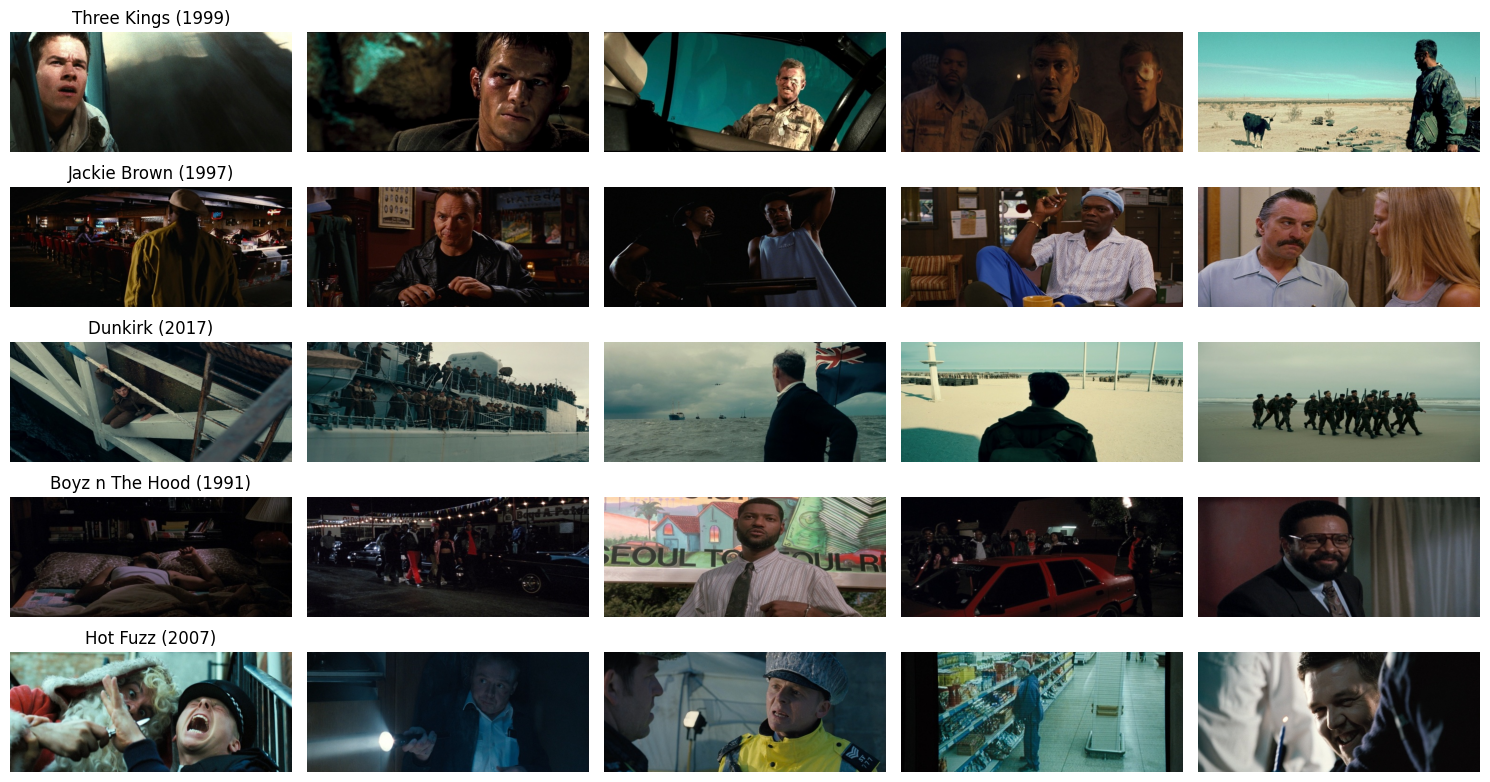

In [12]:
# Let's display some frames from the processed films
import random

random.seed(13)
random_movies = random.sample(processed_movies, 5)
fig, axes = plt.subplots(5, 5, figsize=(15, 8))

for i, movie in enumerate(random_movies):
    movie_path = os.path.join("processed_dataset", movie)
    frames = os.listdir(movie_path)
    random_frames = random.sample(frames, 5)

    for j, frame in enumerate(random_frames):
        frame_path = os.path.join(movie_path, frame)
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0: axes[i, j].set_title(movie)

plt.tight_layout()
plt.show()


# Archiving new datasets

In [13]:
import zipfile

def create_dataset_archive(dataset_name, movie_list, dataset_dir):
    archive_name = f"{dataset_name}.zip"
    with zipfile.ZipFile(archive_name, 'w') as zipf:
        for movie in movie_list:
            dataset_movie_path = os.path.join(dataset_dir, movie)
            for file in os.listdir(dataset_movie_path):
                file_path = os.path.join(dataset_movie_path, file)
                arcname = os.path.join(movie, file)
                zipf.write(file_path, arcname)


In [ ]:
# 1) Dataset with 5 random movies
random_movies_5 = random.sample(processed_movies, 5)
create_dataset_archive("movies_5_processed", random_movies_5, "processed_dataset")


# 2) Dataset with 50 random movies
random_movies_50 = random.sample(processed_movies, 50)
create_dataset_archive("movies_50_processed", random_movies_50, "processed_dataset")


# 3) Dataset with all movies
create_dataset_archive(f"movies_all_processed", processed_movies, "processed_dataset")

In [15]:
from google.colab import drive
drive.mount('/content/drive')

!cp movies_5_processed.zip /content/drive/MyDrive/
!cp movies_50_processed.zip /content/drive/MyDrive/
!cp movies_all_processed.zip /content/drive/MyDrive/


Mounted at /content/drive
